In [1]:
# Are we using a GPU?
!nvidia-smi


Thu Oct 20 14:23:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-20 14:23:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-20 14:23:19 (99.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
# Prepare dataset
train_dir = "/content/drive/MyDrive/dataset_100sr_10tau/training_set"
test_dir = "/content/drive/MyDrive/dataset_100sr_10tau/testing_set"

In [7]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/dataset_100sr_10tau")

There are 3 directories and 0 images in '/content/drive/MyDrive/dataset_100sr_10tau'.
There are 10 directories and 0 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/spikes'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/swells'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/interruptions_harmonics'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/harmonics'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/sags_harmonics'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/interruptions'.
There are 0 directories and 600 images in '/content/drive/MyDrive/dataset_100sr_10tau/training_set/sags'.
There are 0 directories a

In [8]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False) # don't shuffle test data for prediction analysis

Found 6000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


In [9]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                            save_weights_only=True, # save only the model weights
                            monitor="val_accuracy", # save the model weights which score the best validation accuracy
                            save_best_only=True) # only keep the best model weights on file (delete the rest)

In [10]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [11]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
      optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
      metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                      epochs=5, # fit for 5 epochs to keep experiments quick
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                      callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
188/188 [==============================] - 1189s 6s/step - loss: 1.1195 - accuracy: 0.6545 - val_loss: 0.3048 - val_accuracy: 1.0000
Epoch 2/5
188/188 [==============================] - 28s 147ms/step - loss: 0.5862 - accuracy: 0.8400 - val_loss: 0.2483 - val_accuracy: 0.9444
Epoch 3/5
188/188 [==============================] - 26s 136ms/step - loss: 0.4465 - accuracy: 0.8768 - val_loss: 0.1960 - val_accuracy: 0.9444
Epoch 4/5
188/188 [==============================] - 25s 133ms/step - loss: 0.3813 - accuracy: 0.8968 - val_loss: 0.1647 - val_accuracy: 1.0000
Epoch 5/5
188/188 [==============================] - 24s 124ms/step - loss: 0.3394 - accuracy: 0.9068 - val_loss: 0.1882 - val_accuracy: 0.9444


In [14]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

63/63 [==============================] - 313s 5s/step - loss: 0.3498 - accuracy: 0.8845


[0.3497655689716339, 0.8845000267028809]

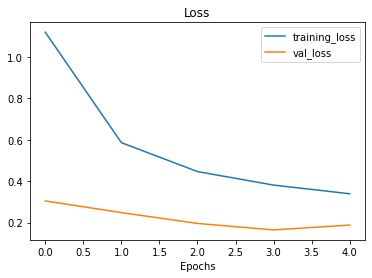

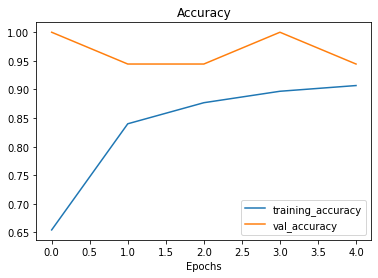

In [15]:
plot_loss_curves(history_all_classes_10_percent)


In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [18]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [19]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                          epochs=fine_tune_epochs,
                          validation_data=test_data,
                          validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                          initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
188/188 [==============================] - 33s 135ms/step - loss: 0.2647 - accuracy: 0.9112 - val_loss: 0.0369 - val_accuracy: 1.0000
Epoch 6/10
188/188 [==============================] - 23s 121ms/step - loss: 0.2123 - accuracy: 0.9280 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 24s 124ms/step - loss: 0.1791 - accuracy: 0.9375 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 8/10
188/188 [==============================] - 22s 116ms/step - loss: 0.1690 - accuracy: 0.9435 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 9/10
188/188 [==============================] - 21s 112ms/step - loss: 0.1539 - accuracy: 0.9478 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 10/10
188/188 [==============================] - 22s 113ms/step - loss: 0.1467 - accuracy: 0.9492 - val_loss: 0.0143 - val_accuracy: 1.0000


In [21]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

63/63 [==============================] - 4s 70ms/step - loss: 0.2029 - accuracy: 0.9240


[0.2028709501028061, 0.9240000247955322]

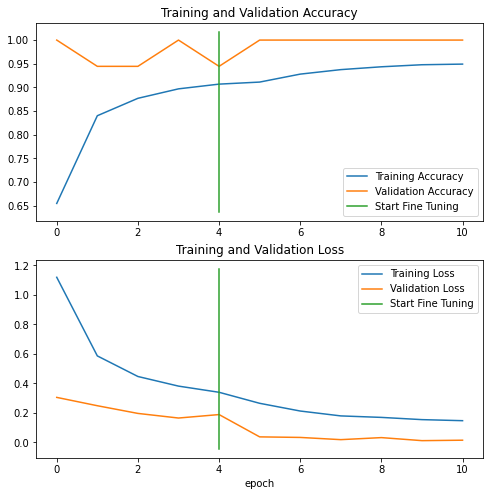

In [22]:
compare_historys(original_history=history_all_classes_10_percent,
        new_history=history_all_classes_10_percent_fine_tune,
        initial_epochs=5)

In [23]:
# Save model to drive so it can be used later
model.save("/content/drive/MyDrive/test_f1_score_fine_tuning1020")

In [24]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

63/63 [==============================] - 7s 70ms/step


In [25]:
# How many predictions are there?
len(pred_probs)

2000

In [26]:
# What's the shape of our predictions?
pred_probs.shape

(2000, 10)

In [27]:
# How do they look?
pred_probs[:10]

array([[9.99987721e-01, 2.44247960e-12, 1.19077413e-11, 1.92979785e-10,
        2.27288721e-09, 7.81948438e-06, 6.93825397e-09, 2.13657802e-12,
        4.37762446e-06, 1.63194280e-09],
       [9.99822438e-01, 5.47695613e-12, 1.98910142e-11, 2.34735065e-10,
        3.48150331e-09, 7.28058731e-05, 5.59553337e-09, 3.11597831e-11,
        1.04703962e-04, 4.41922676e-09],
       [9.99845862e-01, 4.50840892e-10, 1.37179255e-08, 1.68766210e-08,
        2.35533591e-07, 6.98429649e-05, 1.28392585e-07, 6.31381503e-10,
        8.38664782e-05, 1.52999196e-08],
       [9.99809563e-01, 6.07738686e-12, 2.27873883e-11, 2.56479421e-10,
        4.25135793e-09, 8.81117012e-05, 5.93257221e-09, 3.60364759e-11,
        1.02426908e-04, 4.38099290e-09],
       [9.47931528e-01, 1.61899507e-07, 2.76762717e-06, 4.55338437e-07,
        2.62748608e-06, 5.65956114e-03, 6.91481318e-07, 1.31250590e-05,
        4.63887937e-02, 3.30640518e-07],
       [9.99990582e-01, 7.81906874e-13, 2.14956243e-12, 3.95355450e-11,
   

In [28]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 10
What prediction probability sample 0 looks like:
 [9.9998772e-01 2.4424796e-12 1.1907741e-11 1.9297978e-10 2.2728872e-09
 7.8194844e-06 6.9382540e-09 2.1365780e-12 4.3776245e-06 1.6319428e-09]
The class with the highest predicted probability by the model for sample 0: 0


In [29]:
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[150].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[250].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[350].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[450].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[550].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[650].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[750].argmax()}")

The class with the highest predicted probability by the model for sample 210: 0
The class with the highest predicted probability by the model for sample 210: 1
The class with the highest predicted probability by the model for sample 210: 1
The class with the highest predicted probability by the model for sample 210: 2
The class with the highest predicted probability by the model for sample 210: 2
The class with the highest predicted probability by the model for sample 210: 1
The class with the highest predicted probability by the model for sample 210: 3


In [30]:
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[850].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[950].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[1050].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[1150].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[1250].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[1350].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 210: {pred_probs[1450].argmax()}")

The class with the highest predicted probability by the model for sample 210: 4
The class with the highest predicted probability by the model for sample 210: 4
The class with the highest predicted probability by the model for sample 210: 0
The class with the highest predicted probability by the model for sample 210: 5
The class with the highest predicted probability by the model for sample 210: 6
The class with the highest predicted probability by the model for sample 210: 6
The class with the highest predicted probability by the model for sample 210: 7


In [31]:
# Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1).
pred_probs[0].sum()

0.9999999

In [32]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
# To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

2000

In [35]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.924

In [36]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [37]:
# Get the class names
class_names = test_data.class_names
class_names

['flickers',
 'harmonics',
 'interruptions',
 'interruptions_harmonics',
 'osc_transients',
 'sags',
 'sags_harmonics',
 'spikes',
 'swells',
 'swells_harmonics']

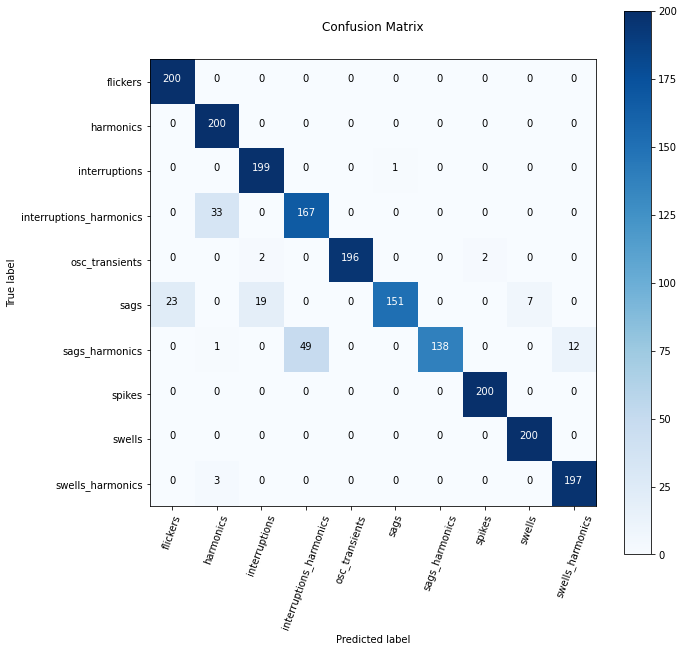

In [38]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
          y_pred=pred_classes,
          classes=class_names,
          figsize=(10, 10),
          text_size=10,
          norm=False,
          savefig=True)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       200
           1       0.84      1.00      0.92       200
           2       0.90      0.99      0.95       200
           3       0.77      0.83      0.80       200
           4       1.00      0.98      0.99       200
           5       0.99      0.76      0.86       200
           6       1.00      0.69      0.82       200
           7       0.99      1.00      1.00       200
           8       0.97      1.00      0.98       200
           9       0.94      0.98      0.96       200

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000

